<a href="https://colab.research.google.com/github/mazharsaif/Attentive-AI-Dockship.io/blob/main/Showcase_89_9323.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Complete notebook and upload


In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mazharjamdar","key":"98bfba3e1d5db3d00136efaed0513add"}'}

In [2]:
!pip install -q kaggle
! mkdir ~/.kaggle/
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mazharjamdar/custom-oversampled-attentive-ai
! unzip '/content/custom-oversampled-attentive-ai.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Custom - Oversampled/training_gen/Shingle/5288.jpg  
  inflating: Custom - Oversampled/training_gen/Shingle/5290 - Copy.jpg  
  inflating: Custom - Oversampled/training_gen/Shingle/5290.jpg  
  inflating: Custom - Oversampled/training_gen/Shingle/5319 - Copy.jpg  
  inflating: Custom - Oversampled/training_gen/Shingle/5319.jpg  
  inflating: Custom - Oversampled/training_gen/Shingle/5322 - Copy.jpg  
  inflating: Custom - Oversampled/training_gen/Shingle/5322.jpg  
  inflating: Custom - Oversampled/training_gen/Shingle/5330 - Copy.jpg  
  inflating: Custom - Oversampled/training_gen/Shingle/5330.jpg  
  inflating: Custom - Oversampled/training_gen/Shingle/5359 - Copy.jpg  
  inflating: Custom - Oversampled/training_gen/Shingle/5359.jpg  
  inflating: Custom - Oversampled/training_gen/Shingle/5362 - Copy.jpg  
  inflating: Custom - Oversampled/training_gen/Shingle/5362.jpg  
  inflating: Custom - Oversampled/training_gen/Sh

In [3]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow_addons.metrics import F1Score # Get F1 score as metric

from sklearn.metrics import classification_report

# Setting some parameters
%matplotlib inline
plt.rcParams['font.size']=12

In [4]:
df = pd.read_csv('/content/Custom - Oversampled/train_df.csv', names=['image_name', 'class'],header=0)
sub = pd.read_csv('/content/Custom - Oversampled/test_challenge.csv',names=['image_name', 'class'],header=0) #Changing column names from 0,1 for convenient handling

df.head()

,image_name,class
0,0.jpg,Adhered
1,1.jpg,Adhered
2,2.jpg,Concrete
3,3.jpg,Concrete
4,4.jpg,Plastic & fabric


Link to data exploration notebook, where I see dimension distribution, previews of images, create train/validation splits and sort files into folders by labels  
https://github.com/mazharsaif/Attentive-AI-Dockship.io/blob/main/90%20Score%20Pre%20model%20exploration.ipynb

In [5]:
def preprocess_custom(np_img, img_height=224, img_width= 224):# contrast_factor=1.3, saturation=1.5
    
    input_arr = tf.keras.preprocessing.image.img_to_array(np_img)

    input_arr = tf.keras.preprocessing.image.smart_resize(input_arr.copy(), size=(224, 224)) # np array
    input_arr = np.array(input_arr, dtype=int)
    input_arr = tf.keras.applications.mobilenet.preprocess_input(input_arr.copy())
    input_arr = tf.image.adjust_saturation(input_arr.copy(), 1.5).numpy()
    input_arr = tf.image.adjust_contrast(input_arr.copy(), 1.3)
    
    return input_arr.numpy()


def plot_total_loss():
    cumulative_history = {key:[] for key in history_1.history.keys()}

    for history_dict in history_list:
        for key in history_dict:
            cumulative_history[key] = cumulative_history[key]+ history_dict[key]
                
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(cumulative_history['accuracy'])
    plt.plot(cumulative_history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.subplot(1,2,2)
    # summarize history for loss
    plt.plot(cumulative_history['loss'])
    plt.plot(cumulative_history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.tight_layout()
    plt.show()


def plot_loss(history_1):
    ## summarize history for accuracy
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(history_1.history['accuracy'])
    plt.plot(history_1.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.subplot(1,2,2)
    # summarize history for loss
    plt.plot(history_1.history['loss'])
    plt.plot(history_1.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.tight_layout()
    plt.show()

def cb(Round_name):
    """ Call back to store model checkpoints separtely by"""
    checkpoint_path = '.weights.{epoch:02d}-{val_loss:.3f}.hdf5'
    
    checkpoint_path = Round_name + checkpoint_path
    
    call_back = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                        monitor='val_loss',
                                        verbose=0,
                                        save_best_only=False,
                                        save_weights_only=False,
                                        mode='auto',
                                        save_freq='epoch',
                                        options=None)
    return call_back

In [6]:
data_dir = '/content/Custom - Oversampled/training_gen'
valid_dir = '/content/Custom - Oversampled/validation_gen'

img_height, img_width= 224, 224 # 512, 512 If use differen, adjust preprocess_custom
batch_size = 32


train_datagen = ImageDataGenerator(width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   brightness_range=None,
                                   rotation_range=5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   preprocessing_function=lambda x: preprocess_custom(x, img_height=img_height, img_width= img_width))

valid_datagen = ImageDataGenerator(width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=None,
                                   rotation_range=5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   preprocessing_function=lambda x: preprocess_custom(x, img_height=img_height, img_width= img_width))

train_datagen_1 = train_datagen.flow_from_directory(data_dir,
                                                   target_size=(img_height, img_width),)

valid_datagen_1 = train_datagen.flow_from_directory(valid_dir,
                                                   target_size=(img_height, img_width))

Found 12439 images belonging to 6 classes.
Found 900 images belonging to 6 classes.


In [8]:
history_list = []

In [8]:
mobilenet = MobileNet(input_shape=None,
                      alpha=1.0,
                      depth_multiplier=1,
                      dropout=0.005,
                      include_top=True,
                      weights="imagenet",
                      input_tensor=None,
                      pooling=None,
                      classes=1000,
                      classifier_activation="softmax")


flattened_2 = tf.keras.layers.Flatten()(mobilenet.output)

#Fully connected layer 1
fc1 = tf.keras.layers.Dense(128, activation='relu', name="AddedDense1")(flattened_2)

#Fully connected layer, output layer
fc2 = tf.keras.layers.Dense(6, activation='softmax', name="AddedDense2")(fc1)

model = tf.keras.models.Model(inputs=mobilenet.input, outputs=fc2)

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
cb_reducelr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=10, verbose=0,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.00000001,
)


In [9]:
# Round A

# Freeze pretrained layers for first round of training
for i in model.layers[:-2]:
    i.trainable=False
    
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(num_classes=6)])

history_1 = model.fit(train_datagen_1,
                      validation_data=valid_datagen_1,
                      steps_per_epoch=380, # 12493/32
                      epochs=5,
                      callbacks=[cb('A')])


history_list.append(history_1.history)

plot_loss(history_1)

Epoch 1/5
380/380 [==============================] - 388s 999ms/step - loss: 1.6748 - accuracy: 0.3527 - f1_score: 0.3250 - val_loss: 1.3728 - val_accuracy: 0.4678 - val_f1_score: 0.4517
Epoch 2/5
380/380 [==============================] - 373s 983ms/step - loss: 1.3235 - accuracy: 0.4994 - f1_score: 0.4926 - val_loss: 1.2441 - val_accuracy: 0.5356 - val_f1_score: 0.5340
Epoch 3/5
380/380 [==============================] - 374s 984ms/step - loss: 1.2453 - accuracy: 0.5277 - f1_score: 0.5234 - val_loss: 1.1929 - val_accuracy: 0.5511 - val_f1_score: 0.5493
Epoch 4/5
217/380 [================>.............] - ETA: 2:27 - loss: 1.2006 - accuracy: 0.5424 - f1_score: 0.5393

KeyboardInterrupt: ignored

In [ ]:
# model = tf.keras.models.load_model('5ep 2layers train.h5')

Epoch 1/7
380/380 [==============================] - 371s 972ms/step - loss: 1.2004 - accuracy: 0.5555 - f1_score: 0.5406 - val_loss: 0.9259 - val_accuracy: 0.6911 - val_f1_score: 0.6900
Epoch 2/7
380/380 [==============================] - 370s 975ms/step - loss: 0.8109 - accuracy: 0.7121 - f1_score: 0.7109 - val_loss: 0.8103 - val_accuracy: 0.7100 - val_f1_score: 0.7128
Epoch 3/7
380/380 [==============================] - 370s 974ms/step - loss: 0.6368 - accuracy: 0.7821 - f1_score: 0.7830 - val_loss: 0.7189 - val_accuracy: 0.7378 - val_f1_score: 0.7418
Epoch 4/7
380/380 [==============================] - 369s 971ms/step - loss: 0.5641 - accuracy: 0.7964 - f1_score: 0.7978 - val_loss: 0.6509 - val_accuracy: 0.7689 - val_f1_score: 0.7678
Epoch 5/7
380/380 [==============================] - 368s 970ms/step - loss: 0.4779 - accuracy: 0.8361 - f1_score: 0.8358 - val_loss: 0.6124 - val_accuracy: 0.7967 - val_f1_score: 0.7968
Epoch 6/7
380/380 [==============================] - 365s 961ms/s

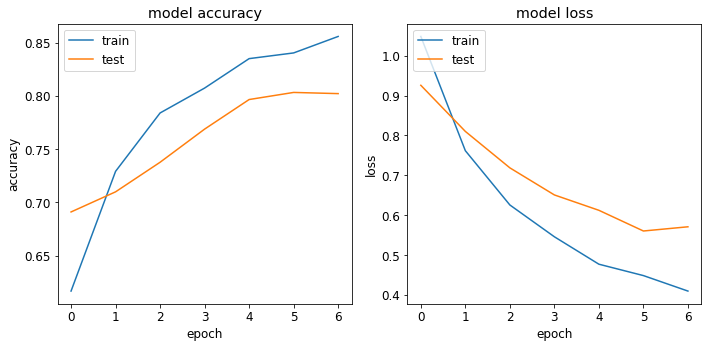

In [ ]:
for i in model.layers[-30:]:
    i.trainable=True

opt_2 =tf.keras.optimizers.Adam(learning_rate=0.00005,
                                beta_1=0.09,
                                beta_2=0.999,
                                epsilon=1e-07,
                                amsgrad=False,
                                name='Adam2')


model.compile(optimizer=opt_2,
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(num_classes=6)])


history_3 = model.fit(train_datagen_1,
                      validation_data=valid_datagen_1,
                      steps_per_epoch=380,
                      epochs=6, # best at 6 
                      callbacks=[cb('B')])#, reduce_lr, early_stop

history_list.append(history_3.history)

plot_loss(history_3)

In [9]:
!kaggle datasets download -d mazharjamdar/score-basic
!unzip 'score-basic.zip'

 68% 25.0M/36.8M [00:00<00:00, 21.9MB/s]
100% 36.8M/36.8M [00:01<00:00, 38.0MB/s]
Archive:  score-basic.zip
  inflating: B.weights.06-0.560.hdf5  


In [10]:
model = tf.keras.models.load_model('B.weights.06-0.560.hdf5')

Epoch 1/3
380/380 [==============================] - 480s 1s/step - loss: 0.4987 - accuracy: 0.8224 - f1_score: 0.8240 - val_loss: 0.6255 - val_accuracy: 0.7967 - val_f1_score: 0.7979
Epoch 2/3
380/380 [==============================] - 471s 1s/step - loss: 0.4183 - accuracy: 0.8543 - f1_score: 0.8557 - val_loss: 0.5004 - val_accuracy: 0.8389 - val_f1_score: 0.8395
Epoch 3/3
380/380 [==============================] - 468s 1s/step - loss: 0.3560 - accuracy: 0.8801 - f1_score: 0.8796 - val_loss: 0.5496 - val_accuracy: 0.8156 - val_f1_score: 0.8177


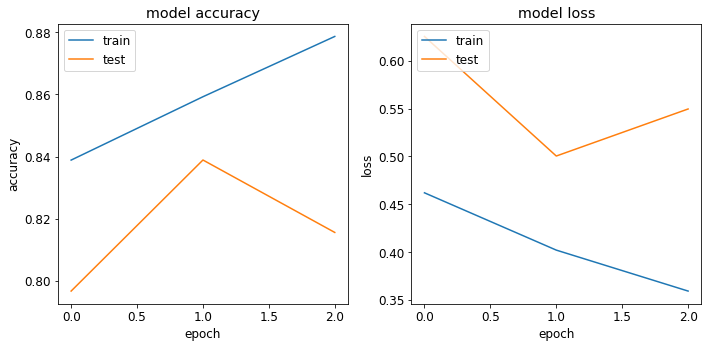

In [11]:
for i in model.layers[-50:]:
    i.trainable=True

opt_3 =tf.keras.optimizers.Adam(learning_rate=0.00005,
                                beta_1=0.09,
                                beta_2=0.999,
                                epsilon=1e-07,
                                amsgrad=False,
                                name='Adam2')


model.compile(optimizer=opt_3,
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(num_classes=6)])


history_3 = model.fit(train_datagen_1,
                      validation_data=valid_datagen_1,
                      steps_per_epoch=380,
                      epochs=3,
                      callbacks=[cb('C')])#, reduce_lr, early_stop

history_list.append(history_3.history)

plot_loss(history_3)

Epoch 1/3
380/380 [==============================] - 479s 1s/step - loss: 0.4157 - accuracy: 0.8516 - f1_score: 0.8520 - val_loss: 0.4716 - val_accuracy: 0.8411 - val_f1_score: 0.8429
Epoch 2/3
380/380 [==============================] - 481s 1s/step - loss: 0.3448 - accuracy: 0.8759 - f1_score: 0.8771 - val_loss: 0.4855 - val_accuracy: 0.8400 - val_f1_score: 0.8420
Epoch 3/3
380/380 [==============================] - 483s 1s/step - loss: 0.3135 - accuracy: 0.8929 - f1_score: 0.8927 - val_loss: 0.4735 - val_accuracy: 0.8467 - val_f1_score: 0.8492


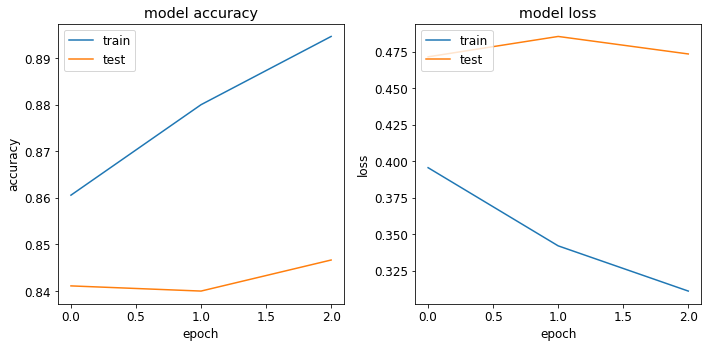

In [12]:
for i in model.layers[-75:]:
    i.trainable=True

opt_3 =tf.keras.optimizers.Adam(learning_rate=0.00005,
                                beta_1=0.09,
                                beta_2=0.999,
                                epsilon=1e-07,
                                amsgrad=False,
                                name='Adam2')


model.compile(optimizer=opt_3,
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(num_classes=6)])


history_4 = model.fit(train_datagen_1,
                      validation_data=valid_datagen_1,
                      steps_per_epoch=380,
                      epochs=3, # turn to 5 
                      callbacks=[cb('D')])#, reduce_lr, early_stop

history_list.append(history_4.history)

plot_loss(history_4)

In [13]:
for i in model.layers[:]:
    i.trainable=True

opt_4 =tf.keras.optimizers.Adam(learning_rate=0.00002,
                                beta_1=0.09,
                                beta_2=0.999,
                                epsilon=1e-07,
                                amsgrad=False,
                                name='Adam2')


model.compile(optimizer=opt_4,
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(num_classes=6)])


history_5 = model.fit(train_datagen_1,
                      validation_data=valid_datagen_1,
                      steps_per_epoch=380,
                      epochs=10, # turn to 5 
                      callbacks=[cb('E')])#, reduce_lr, early_stop

history_list.append(history_5.history)

plot_loss(history_5)

Epoch 1/10
380/380 [==============================] - 528s 1s/step - loss: 0.3630 - accuracy: 0.8735 - f1_score: 0.8742 - val_loss: 0.4771 - val_accuracy: 0.8478 - val_f1_score: 0.8499
Epoch 2/10
380/380 [==============================] - 525s 1s/step - loss: 0.2978 - accuracy: 0.8969 - f1_score: 0.8970 - val_loss: 0.4550 - val_accuracy: 0.8522 - val_f1_score: 0.8532
Epoch 3/10
380/380 [==============================] - 526s 1s/step - loss: 0.2714 - accuracy: 0.9080 - f1_score: 0.9089 - val_loss: 0.4343 - val_accuracy: 0.8678 - val_f1_score: 0.8690
Epoch 4/10
380/380 [==============================] - 525s 1s/step - loss: 0.2590 - accuracy: 0.9100 - f1_score: 0.9110 - val_loss: 0.4092 - val_accuracy: 0.8644 - val_f1_score: 0.8663
Epoch 5/10
380/380 [==============================] - 530s 1s/step - loss: 0.2379 - accuracy: 0.9150 - f1_score: 0.9149 - val_loss: 0.4389 - val_accuracy: 0.8600 - val_f1_score: 0.8611
Epoch 6/10
380/380 [==============================] - 525s 1s/step - loss: 

KeyboardInterrupt: ignored

In [14]:
model_cloned = tf.keras.models.clone_model(model)

-------------

In [15]:
model = tf.keras.models.load_model('/content/E.weights.04-0.409.hdf5')

In [35]:
for i in model.layers[:]:
    i.trainable=True

opt_4 =tf.keras.optimizers.Adam(learning_rate=0.00002,
                                beta_1=0.09,
                                beta_2=0.0999,
                                epsilon=1e-07,
                                amsgrad=False,
                                name='Adam2')


model.compile(optimizer=opt_4,
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(num_classes=6)])


history_5 = model.fit(valid_datagen_1,
                      steps_per_epoch=28,
                      epochs=5), # turn to 5 
                      # callbacks=[cb('F')])#, reduce_lr, early_stop

# history_list.append(history_5.history)

# plot_loss(history_5)

Epoch 1/5
28/28 [==============================] - 38s 1s/step - loss: 0.3619 - accuracy: 0.8826 - f1_score: 0.8825
Epoch 2/5
28/28 [==============================] - 36s 1s/step - loss: 0.3402 - accuracy: 0.8838 - f1_score: 0.8833
Epoch 3/5
28/28 [==============================] - 36s 1s/step - loss: 0.3512 - accuracy: 0.8814 - f1_score: 0.8829
Epoch 4/5
28/28 [==============================] - 36s 1s/step - loss: 0.3742 - accuracy: 0.8691 - f1_score: 0.8710
Epoch 5/5
28/28 [==============================] - 36s 1s/step - loss: 0.3433 - accuracy: 0.8920 - f1_score: 0.8924


AttributeError: ignored

In [41]:
for i in model.layers[:]:
    i.trainable=True

opt_4 =tf.keras.optimizers.Adam(learning_rate=0.00002,
                                beta_1=0.09,
                                beta_2=0.0999,
                                epsilon=1e-07,
                                amsgrad=False,
                                name='Adam2')


model.compile(optimizer=opt_4,
              loss='categorical_crossentropy',
              metrics=['accuracy', F1Score(num_classes=6)])


history_5 = model.fit(valid_datagen_1,
                      steps_per_epoch=28,
                      epochs=5), # turn to 5 
                      # callbacks=[cb('F')])#, reduce_lr, early_stop

# history_list.append(history_5.history)

# plot_loss(history_5)

Epoch 1/5
28/28 [==============================] - 38s 1s/step - loss: 0.3502 - accuracy: 0.8800 - f1_score: 0.8790
Epoch 2/5
28/28 [==============================] - 36s 1s/step - loss: 0.3406 - accuracy: 0.8807 - f1_score: 0.8799
Epoch 3/5
28/28 [==============================] - 36s 1s/step - loss: 0.2228 - accuracy: 0.9234 - f1_score: 0.9218
Epoch 4/5
28/28 [==============================] - 36s 1s/step - loss: 0.2731 - accuracy: 0.9100 - f1_score: 0.9107
Epoch 5/5
28/28 [==============================] - 36s 1s/step - loss: 0.2474 - accuracy: 0.9167 - f1_score: 0.9159


In [ ]:
# model.save('89_93289.hdf5')

Prediction and Validation

In [16]:
# Predicting directly from ImageDataGenerator even with shuffle off cause ordering probeleme
# Hence Creating np array to hold test data

test_images=[]
test_path = '/content/Custom - Oversampled/test/'

for i in sub.image_name:
    path = test_path+i
    img = tf.keras.preprocessing.image.load_img(path,
                                                grayscale=False,
                                                color_mode='rgb')#,
#                                                 target_size=(img_height, img_width),
                                                # interpolation='nearest')
    
    input_arr = preprocess_custom(img, img_height=img_height, img_width= img_width)
    test_images.append(input_arr)
    
test_set = np.array(test_images)

In [17]:
label_list = [i for (i,j) in train_datagen_1.class_indices.items()]
label_map = {j:i for (i,j) in train_datagen_1.class_indices.items()}
label_map

{0: 'Adhered',
 1: 'Ballasted',
 2: 'Concrete',
 3: 'Plastic & fabric',
 4: 'Shingle',
 5: 'Steel'}

In [42]:
predictions = model.predict(test_set)
sub['class'] = predictions.tolist()
sub['class'] = sub['class'].apply(np.argmax).map(label_map)

sub.to_csv('submission.csv', index=False)


from IPython.display import FileLink
FileLink(r'submission.csv')

/content/submission.csv

Validation

In [19]:
valid_df = pd.read_csv('/content/Custom - Oversampled/valid_df.csv')
valid_df.head()

,image_name,class
0,5676.jpg,Adhered
1,2980.jpg,Adhered
2,147.jpg,Adhered
3,2258.jpg,Adhered
4,368.jpg,Adhered


In [20]:
valid_images=[]
valid_path = '/content/Custom - Oversampled/validation/'

for i in valid_df.image_name:
    path = valid_path+i
    img = tf.keras.preprocessing.image.load_img(path,
                                                grayscale=False,
                                                color_mode='rgb',
#                                                 target_size=(img_height, img_width),
                                                interpolation='nearest')

    input_arr = preprocess_custom(img, img_height=img_height, img_width= img_width)
    valid_images.append(input_arr)
    
valid_set = np.array(valid_images)

In [43]:
validation_predictions_prob = model.predict(valid_set)
valid_df['predicted_class'] = validation_predictions_prob.tolist()
valid_df['predicted_class'] = valid_df['predicted_class'].apply(np.argmax).map(label_map)

In [44]:
valid_df.head()

,image_name,class,predicted_class
0,5676.jpg,Adhered,Adhered
1,2980.jpg,Adhered,Adhered
2,147.jpg,Adhered,Adhered
3,2258.jpg,Adhered,Adhered
4,368.jpg,Adhered,Adhered


In [45]:
print(classification_report(valid_df['class'], valid_df['predicted_class']))

                  precision    recall  f1-score   support

         Adhered       0.74      0.79      0.76       150
       Ballasted       0.94      0.93      0.94       150
        Concrete       0.96      0.88      0.92       150
Plastic & fabric       0.92      0.94      0.93       150
         Shingle       0.92      0.95      0.93       150
           Steel       0.80      0.79      0.79       150

        accuracy                           0.88       900
       macro avg       0.88      0.88      0.88       900
    weighted avg       0.88      0.88      0.88       900



In [47]:
def plot_prediction_probablities(index_of_image, prob=validation_predictions_prob):
    
    sns.barplot(x=label_list, y=prob[index_of_image])
    plt.show()